# QC script to calculate sharpness metric for images in a plate

The following script takes an image from the OMERO server, adds increasing levels of blurriness to it and then calculates a 'sharpness' score for the images. 

It highlights the start of an investigation for a workflow that might be used to identify out-of-focus images across a plate of images.


# Workflow summary

![Overview](SharpnessWorkflow.jpg)

### Import Packages that we will need later

In [1]:
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import decimal
import seaborn as sns
from mpl_toolkits.axes_grid1 import AxesGrid
from numpy import array, int8
from skimage import feature
import scipy as sp
from scipy.ndimage import convolve
from scipy import misc, fftpack
from scipy import ndimage

### Create a connection to the OMERO Server

In [3]:
from omero.gateway import BlitzGateway
HOST = 'outreach.openmicroscopy.org'
USERNAME = ''
PASSWORD = ''
PORT = 4064
conn = BlitzGateway(USERNAME, PASSWORD, host=HOST, port=PORT)
conn.connect()

True

### Define the 3 algorithms we are going to test
<br>
The algorithms were sourced from:

* gradientBased - [stackoverflow: Detect which image is sharper](https://stackoverflow.com/questions/6646371/detect-which-image-is-sharper/26014796)
* fourierBased - [Image Sharpness Measure for Blurred Images in Frequency Domain](https://doi.org/10.1016/j.proeng.2013.09.086)
* edgeBased - Canny Edge Detection algorithm scipy (requires prior knowledge about the system)

In [4]:
class AlgorithmList:
    def gradientBasedSharpnessMetric(self):
        gy, gx = np.gradient(plane)
        gnorm = np.sqrt(gx**2 + gy**2)
        sharpness = np.average(gnorm)
        return sharpness
    def fourierBasedSharpnessMetric(self):
        fftimage = np.fft.fft2(plane)
        fftshift = np.fft.fftshift(fftimage)
        fftshift = np.absolute(fftshift)
        M = np.amax(fftshift)
        Th = (fftshift > (M/float(1000))).sum()
        if 'image' in locals():
            sharpness = Th/(float(image.getSizeX())*float(image.getSizeY()))
            return sharpness*10000
        else:
            return Th
    def edgeBasedSharpnessMetric(self):
        edges1 = feature.canny(plane, sigma=3)
        kernel = np.ones((3, 3))
        kernel[1, 1] = 0
        sharpness = convolve(edges1, kernel, mode="constant")
        sharpness = sharpness[edges1 != 0].sum()
        return sharpness
print "loaded:", dir(AlgorithmList)

loaded: ['__doc__', '__module__', 'edgeBasedSharpnessMetric', 'fourierBasedSharpnessMetric', 'gradientBasedSharpnessMetric']


### Choose which algorithm we are going to test

In [9]:
from ipywidgets import widgets
def dropdown_widget(Algorithm_list,
                    dropdown_widget_name,
                    displaywidget=False):

    alg_sel = widgets.Dropdown(
        options=Algorithm_list,
        value=Algorithm_list[0],
        description=dropdown_widget_name,
        disabled=False,
    )
    if displaywidget is True:
        display(alg_sel)
    return alg_sel

Algorithm = dropdown_widget(
    ['Gradient', 'Fourier', 'Edge'],
    'Algorithm: ', True
)
# SELECT THE METHOD THEN MOVE TO THE NEXT CELL WITHOUT RUNNING THE CELL AGAIN

Dropdown(description=u'Algorithm: ', options=('Gradient', 'Fourier', 'Edge'), value='Gradient')

### Example Image from Scipy to test Algorithms

Now create increasing levels of Gaussian blur on an image obtained from Scipy package, and calculate the sharpness of the original and blurred images using the chosen algorithm

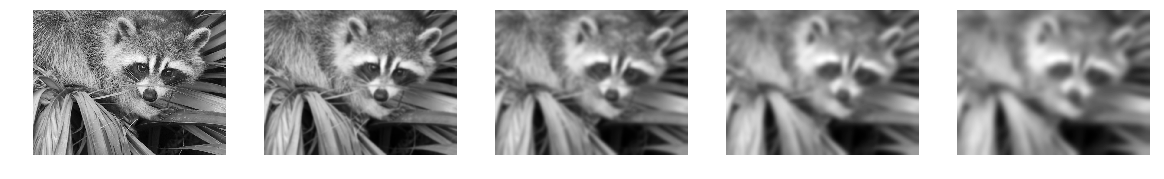

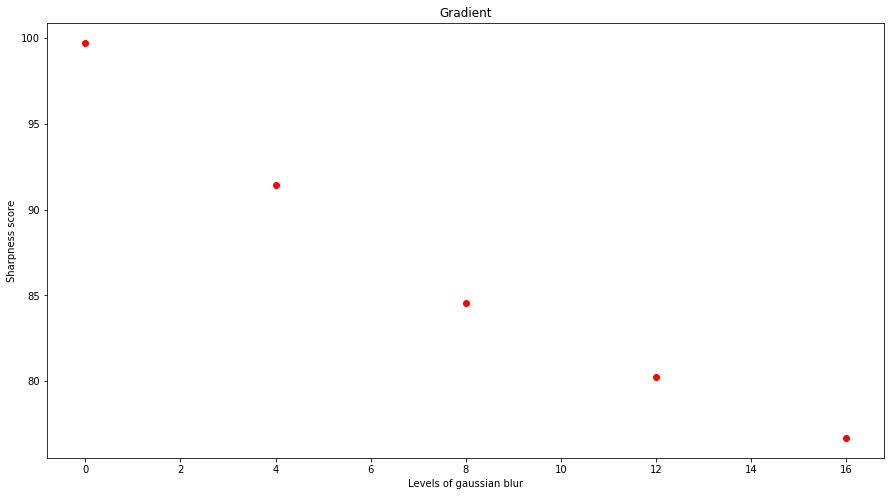

In [6]:
method = Algorithm.value
if method == 'Gradient':
    sharpness_method = AlgorithmList().gradientBasedSharpnessMetric
elif method == 'Fourier':
    sharpness_method = AlgorithmList().fourierBasedSharpnessMetric
elif method == 'Edge':
    sharpness_method = AlgorithmList().edgeBasedSharpnessMetric

import scipy as sp
from scipy import misc
from scipy import ndimage

resultArray = np.zeros((5, 2), dtype=float);
plt.figure(figsize=(20, 15))
cntr = 1
for sigValue in xrange(0,20,4):
    face = misc.face(gray=True)
    plane = ndimage.gaussian_filter(face, sigma=sigValue)
    plt.subplot(1,5,cntr)
    plt.imshow(plane, cmap=plt.cm.gray)
    plt.axis('off')
    sharpness = sharpness_method()
    resultArray[cntr-1,1] = sharpness
    resultArray[cntr-1,0] = sigValue
    cntr= cntr + 1

plt.show()
plt.figure(figsize=(15, 8))
plt.plot(resultArray[:,0], resultArray[:,1], 'ro')
plt.title(method)
plt.xlabel('Levels of gaussian blur')
plt.ylabel('Sharpness score')
plt.show()
plt.gcf().clear() 

### Fetch OMERO Image from the server

In [7]:
imageId = 9397
image = conn.getObject("Image", imageId)
print image.getName(), image.getDescription()

POS218.pattern 


Now create increasing levels of Gaussian blur on an OMERO image, and calculate the sharpness of the original and blurred images using the chosen algorithm

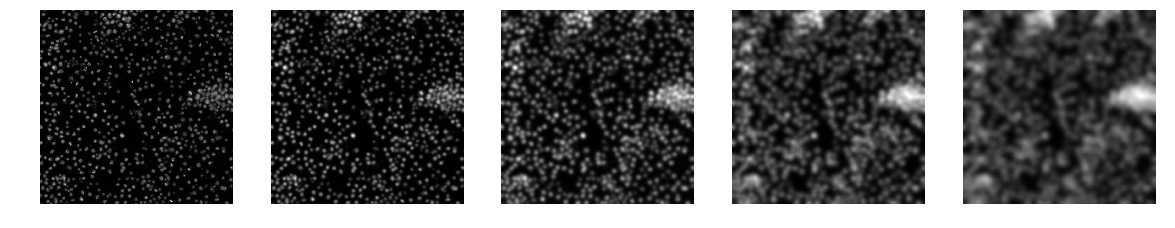

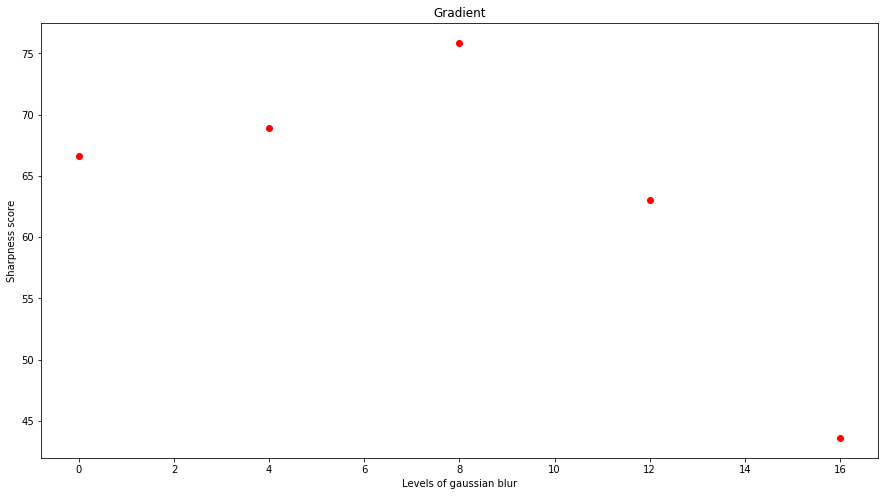

In [8]:
pixels = image.getPrimaryPixels()
image_plane = pixels.getPlane(0, 0, 0)

resultArray = np.zeros((5, 2), dtype=float);
plt.figure(figsize=(20, 15))
cntr = 1
for sigValue in xrange(0,20,4):
    face = misc.face(gray=True)
    plane = ndimage.gaussian_filter(image_plane, sigma=sigValue)
    plt.subplot(1,5,cntr)
    plt.imshow(plane, cmap=plt.cm.gray)
    plt.axis('off')
    sharpness = sharpness_method()
    resultArray[cntr-1,1] = sharpness
    resultArray[cntr-1,0] = sigValue
    cntr = cntr + 1

plt.show()
plt.figure(figsize=(15, 8))
plt.plot(resultArray[:,0], resultArray[:,1], 'ro')
plt.title(method)
plt.xlabel('Levels of gaussian blur')
plt.ylabel('Sharpness score')
plt.show()
plt.gcf().clear()     

### <span style="color:blue">How well did the sharpness algorithm perform?  Try another algorithm to see if it performs better.</span>

<br>
#### When you are completely finished running the notebook close the connection to OMERO server

In [ ]:
conn.close()